In [351]:
from itertools import product
from lib import masters_data_analytics_lib as mlib
from lib import stats as stats
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from statsmodels.graphics.mosaicplot import mosaic

import colorcet as cc
import config_logging
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import pyodbc 
import seaborn as sns
import urllib.request

log = logging.getLogger(__name__)
external_ip = urllib.request.urlopen('https://ident.me').read().decode('utf8')

### Import ./.streamlit/secrets.toml

import toml
secrets = toml.load("./.streamlit/secrets.toml")

database_toml = secrets[secrets["database"]["flavour"]] 

database_props = {
                   "driver"   : database_toml["driver"]
                 , "host"     : database_toml["host"]
                 , "port"     : database_toml["port"]
                 , "instance" : database_toml["instance"]
                 , "database" : database_toml["database"]
                 , "username" : database_toml["username"]
                 , "password" : database_toml["password"]
}
db_conn = None
## Connect to the database -- this might move to a factory method to provide the connection


def get_db_conn(database_props):
    try:                      
        db_conn = pyodbc.connect(driver   = database_props["driver"]
                               , server   = "{},{}\{}".format(database_props["host"], database_props["port"], database_props["instance"])
                               , database = database_props["database"]
                               , uid      = database_props["username"]
                               , pwd      = database_props["password"])

        log.info(f"DATABASE CONNECTIVITY from {external_ip}") 
    except Exception as e:
        log.error(f"NO DATABASE CONNECTIVITY from {external_ip}") 
        log.error(e)
        raise Exception("DATABASE CONNECTIVITY")
        
    return db_conn


In [352]:
## City
city = "london"
search_term = "E1 6AN"

##
## LOAD ALL THE DATA FILES
##
## London Post Codes
sd_london_postcodes_file = "./data/streamlit_{}_postcodes_oa.csv".format(city)
sd_london_population_oa_file = "./data/streamlit_{}_population_oa.csv".format(city)
sd_london_household_oa_file = "./data/streamlit_{}_household_population_oa.csv".format(city)
sd_london_qualification_oa_file = "./data/streamlit_{}_qualifictation_population_oa.csv".format(city)

sd_london_population_oa_df   = mlib.csv_to_dataframe(sd_london_population_oa_file)
sd_london_postcodes_df = mlib.csv_to_dataframe(sd_london_postcodes_file)
sd_london_household_oa_df   = mlib.csv_to_dataframe(sd_london_household_oa_file)
sd_london_qualification_oa_df   = mlib.csv_to_dataframe(sd_london_qualification_oa_file) 


In [353]:
try:
    OAcode = sd_london_postcodes_df.loc[sd_london_postcodes_df["Post_Code"] == search_term]["OAcode"].values[0]
except:
    raise Exception("Unable to find post code {}".format(search_term))

other_post_codes = sd_london_postcodes_df.loc[sd_london_postcodes_df["OAcode"] == OAcode]["Post_Code"].to_numpy()
other_post_codes = np.delete(other_post_codes, np.where(other_post_codes == search_term))
number_of_boroughs = len(sd_london_postcodes_df["borough"].unique())


## Obtain the ward_name from the OACode
ward_name = sd_london_postcodes_df.loc[sd_london_postcodes_df["OAcode"] == OAcode]["WARD_NAME"].values[0]
borough   = sd_london_postcodes_df.loc[sd_london_postcodes_df['OAcode'] == OAcode]["borough"].values[0]

other_wards = sd_london_postcodes_df.loc[sd_london_postcodes_df["borough"] == borough]["WARD_NAME"]
other_wards = other_wards.unique()
other_wards = np.delete(other_wards, np.where(other_wards == borough))

post_code_search_longitude = sd_london_postcodes_df.loc[sd_london_postcodes_df["Post_Code"] == search_term]["longitude"].to_numpy()
post_code_search_latitude = sd_london_postcodes_df.loc[sd_london_postcodes_df["Post_Code"] == search_term]["latitude"].to_numpy()

pc_longitudes = sd_london_postcodes_df.loc[sd_london_postcodes_df["borough"] == borough]["longitude"].to_numpy()
pc_latitudes  = sd_london_postcodes_df.loc[sd_london_postcodes_df["borough"] == borough]["latitude"].to_numpy()


In [245]:
### Stats

###
### Population
###
pop_all_stats	  = stats.generate_stats(sd_london_population_oa_df, borough, ward_name, OAcode, "All")
pop_male_stats	  = stats.generate_stats(sd_london_population_oa_df, borough, ward_name, OAcode, "Males")
pop_female_stats  = stats.generate_stats(sd_london_population_oa_df, borough, ward_name, OAcode, "Females")
pop_density_stats = stats.generate_stats(sd_london_population_oa_df, borough, ward_name, OAcode, "DensityPPH")


In [246]:
### Male female ratio
## OA
pop_male_female_oa_total =pop_male_stats["oacode_sum"] + pop_female_stats["oacode_sum"]
pop_male_oa_ratio = round(pop_male_stats["oacode_sum"]/pop_male_female_oa_total * 100,0)
pop_female_oa_ratio = round(pop_female_stats["oacode_sum"]/pop_male_female_oa_total * 100,0)
log.debug("OA M:{} F:{}".format(pop_male_oa_ratio, pop_female_oa_ratio))

## Ward
pop_male_female_ward_total =pop_male_stats["ward_sum"] + pop_female_stats["ward_sum"]
pop_male_ward_ratio = round(pop_male_stats["ward_sum"]/pop_male_female_oa_total * 100,0)
pop_female_ward_ratio = round(pop_female_stats["ward_sum"]/pop_male_female_oa_total * 100,0)
log.debug("Ward M:{} F:{}".format(pop_male_ward_ratio, pop_female_ward_ratio))

## Borough
pop_male_female_borough_total = pop_male_stats["borough_sum"] + pop_female_stats["borough_sum"]
pop_male_borough_ratio = round(pop_male_stats["borough_sum"]/pop_male_female_borough_total * 100,0)
pop_female_borough_ratio = round(pop_female_stats["borough_sum"]/pop_male_female_borough_total * 100,0)
log.debug("Borough M:{} F:{}".format(pop_male_borough_ratio, pop_female_borough_ratio))

## Borough Average
pop_male_female_city_borough_total = pop_male_stats["city_sum"] + pop_female_stats["city_sum"]
pop_male_city_ratio = round(pop_male_stats["city_sum"]/pop_male_female_city_borough_total * 100,0)
pop_female_city_ratio = round(pop_female_stats["city_sum"]/pop_male_female_city_borough_total * 100,0)

log.debug(pop_male_city_ratio)


2022-08-13 22:22:53,473 [DEBUG] __main__: OA M:64.0 F:36.0
2022-08-13 22:22:53,475 [DEBUG] __main__: Ward M:64.0 F:36.0
2022-08-13 22:22:53,477 [DEBUG] __main__: Borough M:55.0 F:45.0
2022-08-13 22:22:53,480 [DEBUG] __main__: 49.0


2022-08-13 22:22:55,588 [DEBUG] __main__: 
MultiIndex([(             'OA',   'male'),
            (             'OA', 'female'),
            (           'ward',   'male'),
            (           'ward', 'female'),
            (        'borough',   'male'),
            (        'borough', 'female'),
            ('borough average',   'male'),
            ('borough average', 'female')],
           names=['male', 'female'])


<module 'pylab' from 'C:\\DISTRIBUTIONS\\Python\\Python3_10_2\\lib\\site-packages\\pylab.py'>

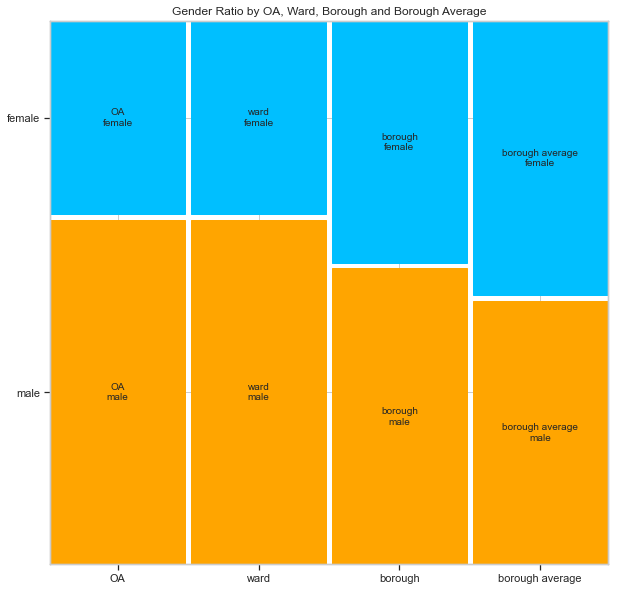

In [247]:
# options == male/female || yes/no
# names   == oa->boroufh avg || male/femal

def mekko_chart(data, options, names, title, props):
    """
    Makes a mekko chart
    """
    ## Changing the order of this will change the axis
    matrix = list(product(names, options))
    index = pd.MultiIndex.from_tuples(matrix, names=options)
    log.debug(f"\n{index}")
    
    data_series = pd.Series(data, index=index)
    mosaic(data_series, gap=[0.01, 0.01], title=title, properties=props)
    
    return pylab

### Call the method

data = [pop_male_oa_ratio
      , pop_female_oa_ratio
      , pop_male_ward_ratio
      , pop_female_ward_ratio
      , pop_male_borough_ratio
      , pop_female_borough_ratio
      , pop_male_city_ratio
      , pop_female_city_ratio
]

options = ["male", "female"]
names = ["OA", "ward", "borough", "borough average"]
title = "Gender Population - OA, Borough and Borough Average"
props = lambda key: {'color': 'orange' if 'male' in key else 'deepskyblue'}
title = "Gender Ratio by OA, Ward, Borough and Borough Average"

mekko_chart(data=data, options=options, names=names, title=title, props=props)


In [248]:
## Connect to database and retrive data from view


db_conn = get_db_conn(database_props)
sql = "SELECT * FROM income_london WHERE [Date] = ? ORDER BY [Date] DESC, [LAD] ASC, [MSOA] ASC"
# data = pd.read_sql(sql, db_conn)  # without parameters [non-prepared statement]

try:
    cursor = db_conn.execute(sql, ("2018"))
except pyodbc.Error as e:
    log.error(e)
    
log.debug(len(cursor.fetchall()))
    
db_conn.close()    


2022-08-13 22:22:58,795 [INFO] __main__: DATABASE CONNECTIVITY from 185.44.76.189
2022-08-13 22:22:59,665 [DEBUG] __main__: 983


In [253]:
## Income for a given post_code -> ward_name -> borough
##
## ward_name will give us the parent msoa so we can get the income for each year within that msoa

year_from = 2012
year_to   = 2018
borough   = "Merton"
ward_name = "Abbey"

db_conn = get_db_conn(database_props)

city_income_min_max_avg_sql ="""
	SELECT [Date] 						                AS [Date]
	      , ROUND(AVG([total_annual_income_net_gbp]),0) AS [city_total_annual_income_net_gbp_avg]
	      , ROUND(MIN([total_annual_income_net_gbp]),0) AS [city_total_annual_income_net_gbp_min]
	      , ROUND(MAX([total_annual_income_net_gbp]),0) AS [city_total_annual_income_net_gbp_max]
	FROM income_uk_ons 		 INC
	WHERE [MSOA] IN (SELECT DISTINCT [LPC].[MSOA] FROM IDX_LONDONPOSTCODES LPC)
	AND   CONVERT(int, [Date]) BETWEEN {} AND {}
	GROUP BY [Date]
	ORDER BY [Date] ASC;
	""".format(year_from, year_to)

city_min_max_avg_df = pd.read_sql_query(city_income_min_max_avg_sql, db_conn, index_col="Date")
# log.debug(city_min_max_avg_df.head())

log.debug(f"year_from:{year_from}")
log.debug(f"year_to:{year_to}")
log.debug(f"borough:{borough}")
log.debug(f"ward_name:{ward_name}")

ward_income_avg_sql = """
SELECT [Date] AS [Date] 
 , ROUND(AVG([total_annual_income_net_gbp]),0) AS [ward_total_annual_income_net_gbp_avg] 
 FROM income_uk_ons 		 INC 
 , IDX_LONDONPOSTCODES LPC 
 WHERE INC.[MSOA] = LPC.[MSOA] 
  AND   INC.[LAD]  = LPC.[LAD] 
 AND   LPC.[LAD_NAME] = '{}' 
 AND   LPC.[WARD_NAME] = '{}' 
 AND   CONVERT(int, [Date]) BETWEEN {} AND {} 
 GROUP BY [Date]
""".format(borough, ward_name, year_from, year_to)

ward_avg_df = pd.read_sql_query(ward_income_avg_sql, db_conn, index_col="Date")
db_conn.close()

## Concatenate the data
city_ward_min_max_avg_wide_df = pd.concat([city_min_max_avg_df, ward_avg_df], axis=1)
city_ward_min_max_avg_wide_df


2022-08-13 22:23:59,730 [INFO] __main__: DATABASE CONNECTIVITY from 185.44.76.189


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-08-13 22:24:00,495 [DEBUG] __main__: year_from:2012
2022-08-13 22:24:00,496 [DEBUG] __main__: year_to:2018
2022-08-13 22:24:00,497 [DEBUG] __main__: borough:Merton
2022-08-13 22:24:00,498 [DEBUG] __main__: ward_name:Abbey


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,city_total_annual_income_net_gbp_avg,city_total_annual_income_net_gbp_min,city_total_annual_income_net_gbp_max,ward_total_annual_income_net_gbp_avg
Date,,,,
2012,46489.0,28600.0,89960.0,63956.0
2014,49004.0,28600.0,88920.0,65955.0
2016,36307.0,25500.0,66200.0,42363.0
2018,43114.0,30800.0,63700.0,54569.0


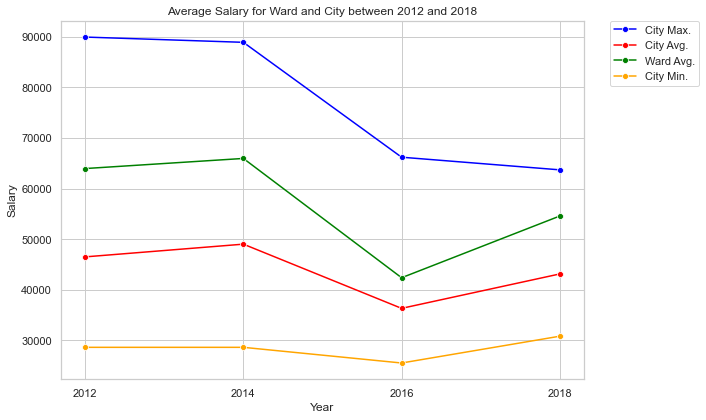

In [254]:
## Make a copy
city_ward_min_max_avg_long_df = city_ward_min_max_avg_wide_df.copy()

## Copy the index to a "Year" Column
city_ward_min_max_avg_long_df["Year"] = city_ward_min_max_avg_long_df.index

## Change to Long from Wide data frame to use in the plot
# city_ward_min_max_avg_long_df = city_ward_min_max_avg_long_df.melt("Year", var_name="cols", value_name="salary")
# log.debug(city_ward_min_max_avg_long_df)

x_fig_size = 10
y_fig_size = 6

## Set the size
sns.set(rc={"figure.figsize":(x_fig_size, y_fig_size)})

## Set the theme
sns.set_style("whitegrid")

# plot = sns.catplot(data=city_ward_min_max_avg_long_df, x="Year", y="salary", hue="cols", kind="point", legend=False, height=y_fig_size, aspect=x_fig_size/y_fig_size)

fig, ax = plt.subplots()
sns.lineplot(data=city_ward_min_max_avg_long_df, x="Year", y="city_total_annual_income_net_gbp_max", ax=ax, label='City Max.', color='blue', marker='o')
sns.lineplot(data=city_ward_min_max_avg_long_df, x="Year", y="city_total_annual_income_net_gbp_avg", ax=ax, label='City Avg.', color='red', marker='o')
sns.lineplot(data=city_ward_min_max_avg_long_df, x="Year", y="ward_total_annual_income_net_gbp_avg", ax=ax, label='Ward Avg.', color='green', marker='o')
sns.lineplot(data=city_ward_min_max_avg_long_df, x="Year", y="city_total_annual_income_net_gbp_min", ax=ax, label='City Min.', color='orange', marker='o')

ax.set_title("Average Salary for Ward and City between {} and {}".format(year_from, year_to))
ax.set_ylabel("Salary")


ax.legend(title="legend")
ax.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()




In [255]:
db_conn = get_db_conn(database_props)

year_from = 2012
year_to   = 2018


borough_salary_ranking_by_year_sql = """
WITH ranked_income_uk_ons AS (
SELECT [INC].[Date]     AS [Date]
     , [INC].[LAD]      AS [LAD]
     , AVG([INC].[total_annual_income_net_gbp]) AS [total_annual_income_net_gbp_avg]
FROM income_uk_ons INC
WHERE [INC].[MSOA] IN (SELECT DISTINCT [LPC2].[MSOA] FROM IDX_LONDONPOSTCODES LPC2)
GROUP BY [INC].[Date], [INC].[LAD]
)
SELECT [RINC].[Date]                                                 AS [Date]
     , [RINC].[LAD]                                                  AS [LAD] 
     , [LB].[borough]                                                AS [borough]
     , [RINC].[total_annual_income_net_gbp_avg] 				     AS [total_annual_income_net_gbp_avg]
     , ROW_NUMBER() OVER(
     				PARTITION BY [Date] 
     				ORDER BY [Date] DESC
     				       , [total_annual_income_net_gbp_avg] DESC) AS RANK
FROM ranked_income_uk_ons RINC
CROSS APPLY(
	SELECT TOP 1 [LPC3].[LAD_NAME] AS [borough]
	FROM IDX_LONDONPOSTCODES LPC3
	WHERE [LPC3].[LAD] = [RINC].[LAD]) AS LB
WHERE CONVERT(int, [Date]) BETWEEN {} AND {}
ORDER BY [Date] DESC, [RANK] ASC"""

# borough_salary_ranking_by_year_df = pd.DataFrame([])
if borough_salary_ranking_by_year_df.empty:
    borough_salary_ranking_by_year_df = pd.read_sql_query(borough_salary_ranking_by_year_sql.format(year_from, year_to), db_conn, index_col="Date")

    
borough_salary_ranking_by_year_df["Year"] = borough_salary_ranking_by_year_df.index
borough_salary_ranking_by_year_df

## Create our palette of a list of tuples
# palette = sns.color_palette("Blues", n_colors=33)
## Reverse it get the darkest colour first
# palette.reverse()

## Convert into a list
# palette = list(palette)

# log.debug(f"palette as list:{palette}")
# palette = [(0.03137254901960784, 0.2166551326412918, 0.46180699730872743), (0.03137254901960784, 0.2491349480968858, 0.5100346020761246), (0.03137254901960784, 0.27755478662053057, 0.5522337562475971), (0.03137254901960784, 0.31003460207612454, 0.6004613610149943), (0.0471357170319108, 0.3378239138792772, 0.6275278738946559), (0.07174163783160323, 0.3693194925028835, 0.6521337946943484), (0.09327181853133411, 0.396878123798539, 0.6736639753940792), (0.11787773933102653, 0.4283737024221453, 0.6982698961937717), (0.1426066897347174, 0.45633217993079583, 0.7166013071895425), (0.17508650519031155, 0.4888119953863899, 0.7333333333333334), (0.2035063437139562, 0.5172318339100346, 0.7479738562091504), (0.23598615916955018, 0.5497116493656286, 0.7647058823529412), (0.265759323337178, 0.5772856593617839, 0.7791772395232603), (0.3061130334486736, 0.6048442906574394, 0.7949250288350634), (0.3414225297962322, 0.628958093041138, 0.8087043444828912), (0.3817762399077278, 0.6565167243367935, 0.8244521337946944), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221), (0.4666666666666667, 0.7081891580161477, 0.8493656286043829), (0.5168627450980392, 0.7357477893118032, 0.8601922337562476), (0.5607843137254902, 0.7598615916955017, 0.8696655132641292), (0.6109803921568627, 0.7874202229911572, 0.8804921184159938), (0.647289504036909, 0.803921568627451, 0.8920415224913495), (0.6866589773164169, 0.8206535947712418, 0.9058208381391772), (0.7211072664359862, 0.8352941176470587, 0.9178777393310266), (0.760476739715494, 0.8520261437908496, 0.9316570549788543), (0.7875432525951558, 0.8662053056516724, 0.9409457900807382), (0.8111649365628605, 0.8819530949634755, 0.9488196847366398), (0.8318339100346022, 0.8957324106113033, 0.9557093425605536), (0.8554555940023069, 0.9114801999231065, 0.9635832372164552), (0.8763552479815455, 0.9252595155709342, 0.970472895040369), (0.900961168781238, 0.9410073048827373, 0.9783467896962706), (0.9224913494809689, 0.9547866205305651, 0.9852364475201846), (0.9470972702806613, 0.9705344098423683, 0.9931103421760861)]
# palettex = [item for t in palette for item in t]
# log.debug(f"palettex:{palettex}")




for year in borough_salary_ranking_by_year_df["Year"].unique(): 
    custom_pallete = ["deepskyblue"] * 33
    data = borough_salary_ranking_by_year_df.loc[borough_salary_ranking_by_year_df["Year"] == year]
    colour_idx =  data.loc[data["borough"] == borough]["RANK"].values[0]

    custom_pallete = custom_pallete[:colour_idx-1]+["orange"]+custom_pallete[colour_idx:]

    fig, ax = plt.subplots()
    sns.barplot(data["total_annual_income_net_gbp_avg"], data["borough"], palette=custom_pallete)
    ax.set_title("Average Income Rankings by Borough {}".format(year))
    ax.set_ylabel("Borough")
    ax.set_xlabel("Average Income")
    plt.tight_layout()
    plt.show()

db_conn.close()


2022-08-13 22:24:07,965 [INFO] __main__: DATABASE CONNECTIVITY from 185.44.76.189


KeyError: 'borough'

In [256]:
## EARNINGS

year_from = 2010
year_to   = 2021
borough   = "Islington"

db_conn = get_db_conn(database_props)

london_mean_earnings_min_max_avg_sql ="""
	SELECT [LEO].[Date] 				       AS [DATE]
	 , ROUND(AVG([LEO].[MEAN_INCOME]),0) AS [CITY_MEAN_INCOME_GBP_AVG]
	 , ROUND(MIN([LEO].[MEAN_INCOME]),0) AS [CITY_MEAN_INCOME_GBP_MIN]
	 , ROUND(MAX([LEO].[MEAN_INCOME]),0) AS [CITY_MEAN_INCOME_GBP_MAX]
	FROM LONDON_EARNINGS_ON LEO
	WHERE   CONVERT(int, [LEO].[Date]) BETWEEN {} AND {}
	GROUP BY [LEO].[Date]
	ORDER BY [LEO].[Date] ASC;
	""".format(year_from, year_to)

city_min_max_avg_df = pd.read_sql_query(london_mean_earnings_min_max_avg_sql, db_conn, index_col="DATE")

log.debug(f"year_from:{year_from}")
log.debug(f"year_to:{year_to}")
log.debug(f"borough:{borough}")
log.debug(f"ward_name:{ward_name}")

borough_income_sql = """
SELECT [LEO].[Date] 		AS [DATE]
	 , [LEO].[MEAN_INCOME]	AS [BOROUGH_MEAN_INCOME_GBP_AVG]
	FROM LONDON_EARNINGS_ON LEO
	WHERE [LEO].[BOROUGH] = '{}'
	AND   CONVERT(int, [LEO].[Date]) BETWEEN {} AND {}
	ORDER BY [LEO].[Date] ASC;""".format(borough, year_from, year_to)

borough_avg_df = pd.read_sql_query(borough_income_sql, db_conn, index_col="DATE")
db_conn.close()

## Concatenate the data
city_borough_min_max_avg_wide_df = pd.concat([city_min_max_avg_df, borough_avg_df], axis=1)
city_borough_min_max_avg_wide_df

2022-08-13 22:24:37,143 [INFO] __main__: DATABASE CONNECTIVITY from 185.44.76.189
2022-08-13 22:24:37,187 [DEBUG] __main__: year_from:2010
2022-08-13 22:24:37,188 [DEBUG] __main__: year_to:2021
2022-08-13 22:24:37,188 [DEBUG] __main__: borough:Islington
2022-08-13 22:24:37,189 [DEBUG] __main__: ward_name:Abbey


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,CITY_MEAN_INCOME_GBP_AVG,CITY_MEAN_INCOME_GBP_MIN,CITY_MEAN_INCOME_GBP_MAX,BOROUGH_MEAN_INCOME_GBP_AVG
DATE,,,,
2010,33658.0,24279.0,82218.0,44553.0
2011,34290.0,24026.0,88064.0,53599.0
2012,33571.0,23876.0,83750.0,51272.0
2013,33350.0,23549.0,79149.0,50615.0
2014,33041.0,21760.0,78999.0,53023.0
2015,32966.0,22851.0,73479.0,44371.0
2016,33667.0,24414.0,75524.0,47353.0
2017,34476.0,24006.0,75996.0,47257.0
2018,35385.0,23480.0,84609.0,46701.0


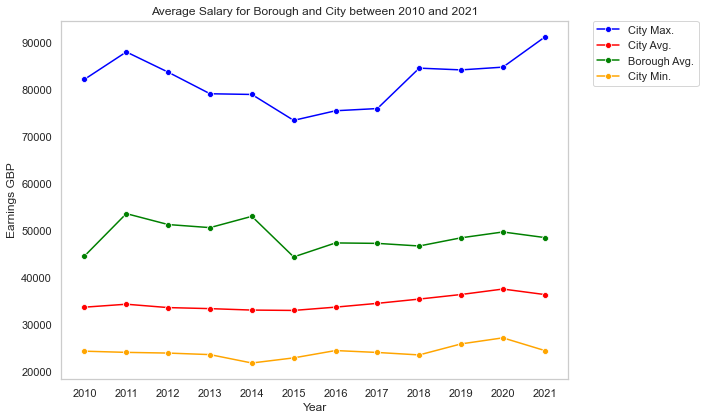

In [257]:
## Copy the index to a "Year" Column
city_borough_min_max_avg_wide_df["YEAR"] = city_borough_min_max_avg_wide_df.index

x_fig_size = 10
y_fig_size = 6

## Set the size
sns.set(rc={"figure.figsize":(x_fig_size, y_fig_size)})

## Set the theme
sns.set_style("whitegrid")

# plot = sns.catplot(data=city_ward_min_max_avg_long_df, x="Year", y="salary", hue="cols", kind="point", legend=False, height=y_fig_size, aspect=x_fig_size/y_fig_size)

fig, ax = plt.subplots()
sns.lineplot(data=city_borough_min_max_avg_wide_df, x="YEAR", y="CITY_MEAN_INCOME_GBP_MAX", ax=ax,    label='City Max.', color='blue', marker='o')
sns.lineplot(data=city_borough_min_max_avg_wide_df, x="YEAR", y="CITY_MEAN_INCOME_GBP_AVG", ax=ax,    label='City Avg.', color='red', marker='o')
sns.lineplot(data=city_borough_min_max_avg_wide_df, x="YEAR", y="BOROUGH_MEAN_INCOME_GBP_AVG", ax=ax, label='Borough Avg.', color='green', marker='o')
sns.lineplot(data=city_borough_min_max_avg_wide_df, x="YEAR", y="CITY_MEAN_INCOME_GBP_MIN", ax=ax,    label='City Min.', color='orange', marker='o')

ax.set_title("Average Salary for Borough and City between {} and {}".format(year_from, year_to))
ax.set_xlabel("Year")
ax.set_ylabel("Earnings GBP")
ax.grid(False)


ax.legend(title="legend")
ax.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()


### EARNINGS BOROUGH - DATA - CACHED

In [356]:
from data.daos import dao_facade_local as dao_fac

db_conn = get_db_conn(database_props)


2022-08-14 17:08:59,414 [INFO] __main__: DATABASE CONNECTIVITY from 185.44.76.189


In [259]:
borough_salary_ranking_by_year_df = dao_fac.earnings_ranked_by_borough_years(db_conn)

# borough_salary_ranking_by_year_df

2022-08-13 22:24:47,067 [DEBUG] root: Retrieving Crime Ranked By Borough Years


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


### EARNINGS - BOROUGH - BUMP CHART

In [260]:
year_from = 2010
year_to   = 2020
borough   = "Islington"
borough   = "Barking and Dagenham"

borough_earnings_ranking_filtered_year_df = borough_salary_ranking_by_year_df[(borough_salary_ranking_by_year_df["YEAR"].astype(int) >= year_from) & (borough_salary_ranking_by_year_df["YEAR"].astype(int) <= year_to)]

years_sorted = borough_earnings_ranking_filtered_year_df["YEAR"].sort_values().drop_duplicates()
first_year = years_sorted.iloc[0]
borough_sort_order = borough_earnings_ranking_filtered_year_df.loc[borough_earnings_ranking_filtered_year_df["YEAR"]==first_year]["BOROUGH"]
top_borough = borough_sort_order.iloc[0]
mid_borough = borough_sort_order.iloc[16]
bottom_borough = borough_sort_order.iloc[-1]

## Loop through the boroughs in the sort order of first year
all_borough_ranking_by_year = []

## BOROUGH LOOP
for _borough in borough_sort_order:

    borough_ranking_by_year_list = []

    ## Add the Borough
    borough_ranking_by_year_list.append(_borough)

    ## YEAR LOOP
    for year in years_sorted:

        borough_ranking_for_year = borough_earnings_ranking_filtered_year_df.loc[(borough_earnings_ranking_filtered_year_df["BOROUGH"]==_borough) &
                                      (borough_earnings_ranking_filtered_year_df["YEAR"]==year)]["RANK"].values[0]

        borough_ranking_by_year_list.append(borough_ranking_for_year)

    all_borough_ranking_by_year.append(borough_ranking_by_year_list)

columns = ["Borough"] + list(years_sorted)

all_borough_ranking_by_year_df = pd.DataFrame(all_borough_ranking_by_year, columns=columns).set_index("Borough")

tmb_borough_ranking_by_year_df = all_borough_ranking_by_year_df.copy()

tmb_borough_ranking_by_year_df = tmb_borough_ranking_by_year_df.loc[(tmb_borough_ranking_by_year_df.index == top_borough) | 
                                                                    (tmb_borough_ranking_by_year_df.index == mid_borough) |
                                                                    (tmb_borough_ranking_by_year_df.index == borough) | 
                                                                    (tmb_borough_ranking_by_year_df.index == bottom_borough)]


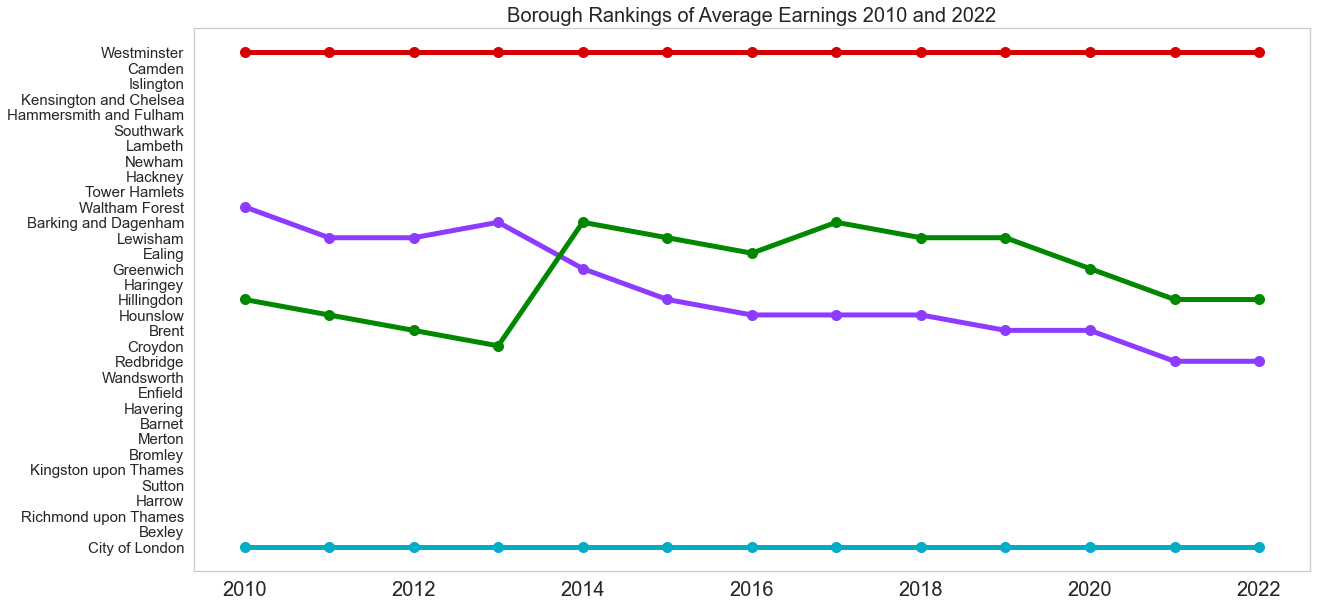

In [319]:
####
#### CREATE THE MAIN REPORT PLOT OF TOP, MID, BOTTOM
#### 

palette = sns.color_palette(cc.glasbey, n_colors=len(tmb_borough_ranking_by_year_df.index.values))
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())
ax = tmb_borough_ranking_by_year_df.T.plot(figsize=(20, 10), marker="o",  ms=5, cmap=my_cmap)

ax.grid(False)
ax.set_title("Borough Rankings of Average Earnings {} and {}".format(year_from, year_to), fontsize=20)

plt.xticks(fontsize=20)

# Generate labels from the Borough names for the Y Axis
plt.yticks(range(1, len(borough_sort_order)+1), [borough_sort_order.iloc[i] for i in range(len(borough_sort_order))])
plt.yticks(fontsize=15)
plt.xticks(fontsize=20)

plt.gca().invert_yaxis()
plt.gca().get_legend().remove()

for line in ax.get_lines():
    if (line.get_label() == borough) or (line.get_label() == top_borough) or (line.get_label() == mid_borough) or (line.get_label() == bottom_borough):
        line.set_linewidth(5)
        line.set_ms(10)
    else:
        line.set_linewidth(2)
        line.set_ms(4)
        line.set_alpha(0.0)

plt.show(block=True)


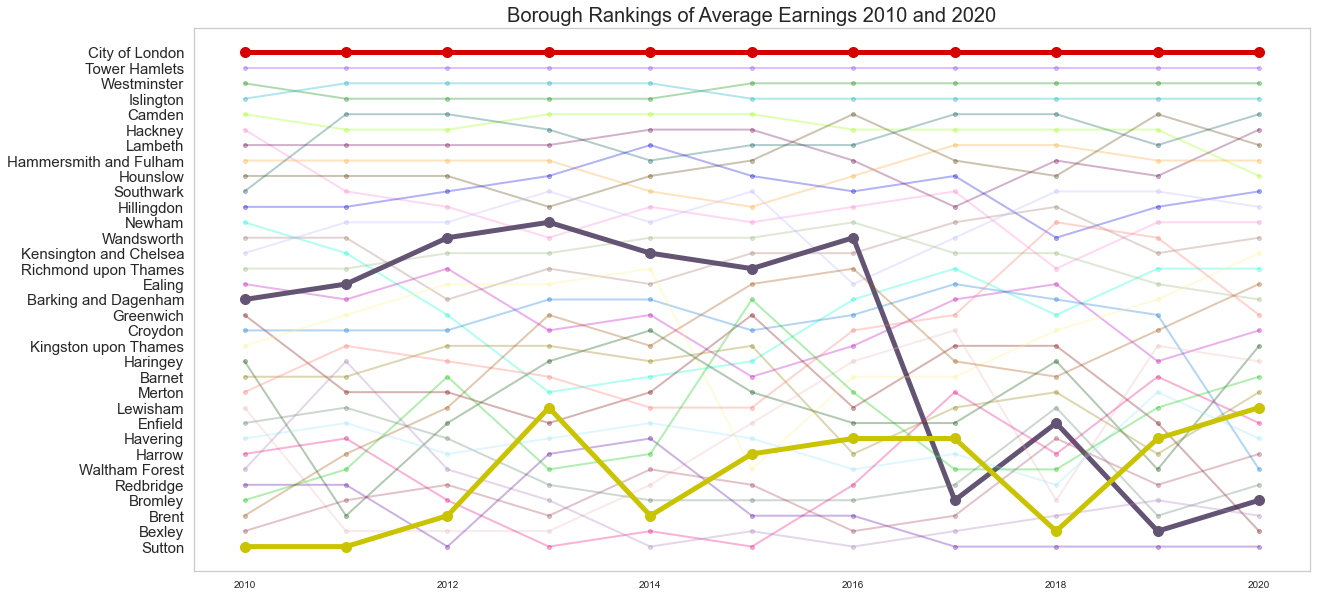

In [262]:
####
#### CREATE THE PLOTS - APPENDICES VERSION
#### 

palette = sns.color_palette(cc.glasbey, n_colors=len(borough_sort_order))
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())
ax = all_borough_ranking_by_year_df.T.plot(figsize=(20, 10), marker="o",  ms=5, cmap=my_cmap)

ax.grid(False)
ax.set_title("Borough Rankings of Average Earnings {} and {}".format(year_from, year_to), fontsize=20)

plt.xticks(fontsize=10)

## Generate labels from the Borough names for the Y Axis
plt.yticks(range(1, len(borough_sort_order)+1), [borough_sort_order.iloc[i] for i in range(len(borough_sort_order))])
plt.yticks(fontsize=15)

plt.gca().invert_yaxis()
plt.gca().get_legend().remove()

for line in ax.get_lines():
    if (line.get_label() == borough) or (line.get_label() == top_borough) or (line.get_label() == mid_borough) or (line.get_label() == bottom_borough):
        line.set_linewidth(5)
        line.set_ms(10)
    else:
        line.set_linewidth(2)
        line.set_ms(4)
        line.set_alpha(0.3)

plt.show(block=True)
    

### CRIME BOROUGH - DATA - CACHED

In [263]:
### Set up

from data.daos import dao_facade_local as dao_fac

db_conn = get_db_conn(database_props)


2022-08-13 22:24:59,607 [INFO] __main__: DATABASE CONNECTIVITY from 185.44.76.189


In [265]:
### Data Load

borough_crime_per_capita_by_year_df = dao_fac.crime_ranked_by_borough_years(db_conn)

borough_crime_per_capita_by_year_df

,YEAR,LAD_CODE,LAD_NAME,BOROUGH_TOTAL_CRIME,BOROUGH_POPULATION,CRIMES_PER_PERSON,RANK
0,2022,E09000033,Westminster,27278.0,257302.0,0.10602,1
1,2022,E09000007,Camden,13785.0,257615.0,0.05351,2
2,2022,E09000019,Islington,11071.0,240594.0,0.04602,3
3,2022,E09000030,Tower Hamlets,13436.0,296813.0,0.04527,4
4,2022,E09000020,Kensington and Chelsea,8237.0,185320.0,0.04445,5
...,...,...,...,...,...,...,...
721,2001,E09000003,Barnet,28059.0,317234.0,0.08845,29
722,2001,E09000029,Sutton,14713.0,169257.0,0.08693,30
723,2001,E09000027,Richmond upon Thames,14173.0,166447.0,0.08515,31
724,2001,E09000015,Harrow,17178.0,212793.0,0.08073,32


### CRIME - BOROUGH - BUMP CHART

In [345]:
year_from = 2010
year_to   = 2022
borough   = "Kensington and Chelsea"

log.debug("Start Loading borough_crime_per_capita_filtered_year_df")


log.debug("End Loading borough_crime_per_capita_filtered_year_df")

borough_crime_per_capita_filtered_year_df = borough_crime_per_capita_by_year_df[(borough_crime_per_capita_by_year_df["YEAR"].astype(int) >= year_from) & (borough_crime_per_capita_by_year_df["YEAR"].astype(int) <= year_to)]

years_sorted = borough_crime_per_capita_filtered_year_df["YEAR"].sort_values().drop_duplicates()
first_year = years_sorted.iloc[0]

borough_sort_order = borough_crime_per_capita_filtered_year_df.loc[borough_crime_per_capita_filtered_year_df["YEAR"]==first_year]["LAD_NAME"]
top_borough = borough_sort_order.iloc[0]
mid_borough = borough_sort_order.iloc[16]
bottom_borough = borough_sort_order.iloc[-1]


## Loop through the boroughs in the sort order of first year
all_borough_ranking_by_year = []

## BOROUGH LOOP
for _borough in borough_sort_order:

    borough_ranking_by_year_list = []

    ## Add the Borough
    borough_ranking_by_year_list.append(_borough)

    ## YEAR LOOP
    for year in years_sorted:

        borough_ranking_for_year = borough_crime_per_capita_filtered_year_df.loc[(borough_crime_per_capita_filtered_year_df["LAD_NAME"]==_borough) &
                                      (borough_crime_per_capita_filtered_year_df["YEAR"]==year)]["RANK"].values[0]

        borough_ranking_by_year_list.append(borough_ranking_for_year)

    all_borough_ranking_by_year.append(borough_ranking_by_year_list)

columns = ["Borough"] + list(years_sorted)

all_borough_ranking_by_year_df = pd.DataFrame(all_borough_ranking_by_year, columns=columns).set_index("Borough")

tmb_borough_ranking_by_year_df = all_borough_ranking_by_year_df.copy()

tmb_borough_ranking_by_year_df = tmb_borough_ranking_by_year_df.loc[(tmb_borough_ranking_by_year_df.index == top_borough) | 
                                                                    (tmb_borough_ranking_by_year_df.index == mid_borough) |
                                                                    (tmb_borough_ranking_by_year_df.index == borough) | 
                                                                    (tmb_borough_ranking_by_year_df.index == bottom_borough)]

borough_ranking_by_year_df = tmb_borough_ranking_by_year_df.loc[(tmb_borough_ranking_by_year_df.index == borough)]

## Textual trend based on linear regression coefficient
## -ve then increasing i.e. going from a lower to higher ranking per capita
## +ve then decreasing i.e. going from a higher to lower ranking per capita
##   0 then flat

y = [borough_ranking_by_year_df.loc[borough].tolist()]

x = [int(x) for x in borough_ranking_by_year_df.columns.tolist()]
# x = [int(borough_ranking_by_year_df.columns.tolist())]

log.debug(f"y:{y}")
log.debug(f"x:{X}")

import matplotlib.pyplot as plt
from scipy import stats

# x = [5,7,8,7,2,17,2,9,4,11,12,9,6]
# y = [99,86,87,88,111,86,103,87,94,78,77,85,86]

slope, intercept, r, p, std_err = stats.linregress(x, y)

# def myfunc(x):
#   return slope * x + intercept

# mymodel = list(map(myfunc, x))

# plt.scatter(x, y)
# plt.plot(x, mymodel)
# plt.show()

log.debug(slope)
rate = ""
if slope == 0:
    rate = "is level"
elif slope < 0:    
    if slope >= -0.1:
        rate = "has slightly increased"
    elif slope >= - 0.5:
        rate = "has moderatly increased"
    else:
        rate = "has greatly increased"
else:
    if slope <= 0.1:
        rate = "has slightly decreased"
    elif slope <= 0.5:
        rate = "has moderatly decreased"
    else:
        rate = "has greatly decreasd"

log.debug(f"Crime {rate} over the period")



2022-08-14 16:11:01,704 [DEBUG] __main__: Start Loading borough_crime_per_capita_filtered_year_df
2022-08-14 16:11:01,706 [DEBUG] __main__: End Loading borough_crime_per_capita_filtered_year_df
2022-08-14 16:11:02,001 [DEBUG] __main__: y:[[4, 5, 4, 4, 4, 4, 4, 4, 4, 3, 6, 6, 5]]
2022-08-14 16:11:02,003 [DEBUG] __main__: x:[['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']]
2022-08-14 16:11:02,004 [DEBUG] __main__: 0.08791208791208792
2022-08-14 16:11:02,006 [DEBUG] __main__: Crime has slightly decreased over the period


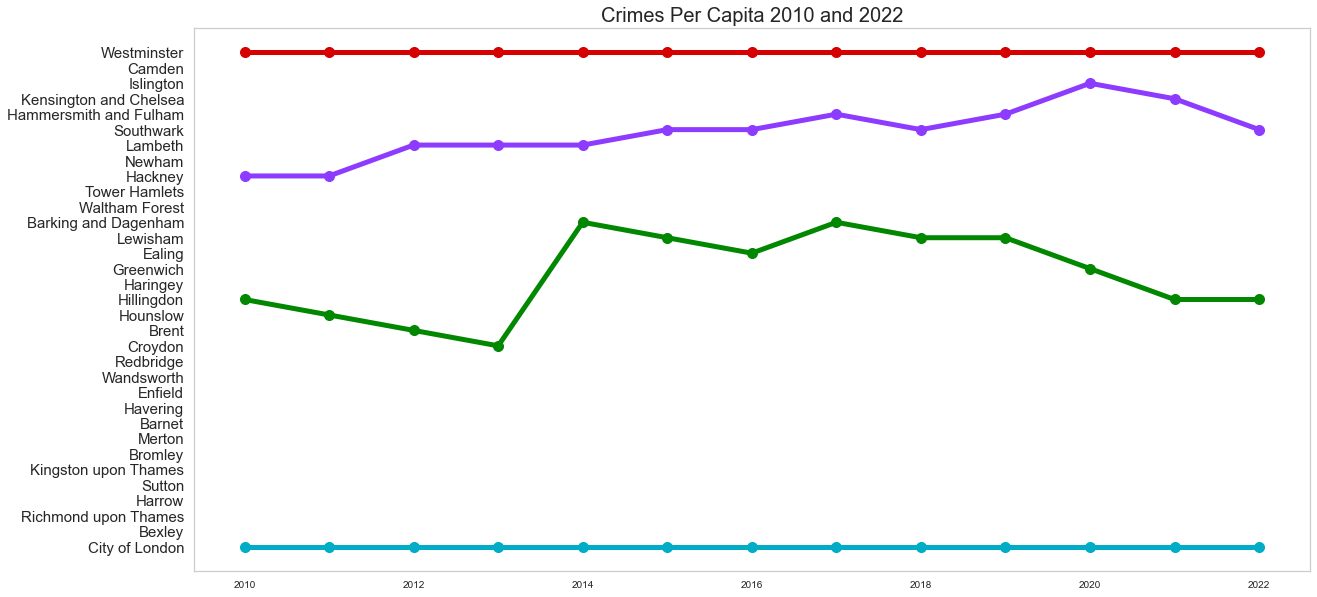

In [313]:
####
#### CREATE THE MAIN REPORT PLOT OF TOP, MID, BOTTOM
#### 

palette = sns.color_palette(cc.glasbey, n_colors=len(tmb_borough_ranking_by_year_df.index.values))
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())
ax = tmb_borough_ranking_by_year_df.T.plot(figsize=(20, 10), marker="o",  ms=5, cmap=my_cmap)

ax.grid(False)
ax.set_title("Crimes Per Capita {} and {}".format(year_from, year_to), fontsize=20)

plt.xticks(fontsize=20)

## Generate labels from the Borough names for the Y Axis

plt.yticks(range(1, len(borough_sort_order)+1), [borough_sort_order.iloc[i] for i in range(len(borough_sort_order))])
plt.yticks(fontsize=15)
plt.xticks(fontsize=10)

ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.gca().invert_yaxis()
plt.gca().get_legend().remove()

for line in ax.get_lines():
    if (line.get_label() == borough) or (line.get_label() == top_borough) or (line.get_label() == mid_borough) or (line.get_label() == bottom_borough):
        line.set_linewidth(5)
        line.set_ms(10)
    else:
        line.set_linewidth(2)
        line.set_ms(4)
        line.set_alpha(0.0)

plt.show(block=True)


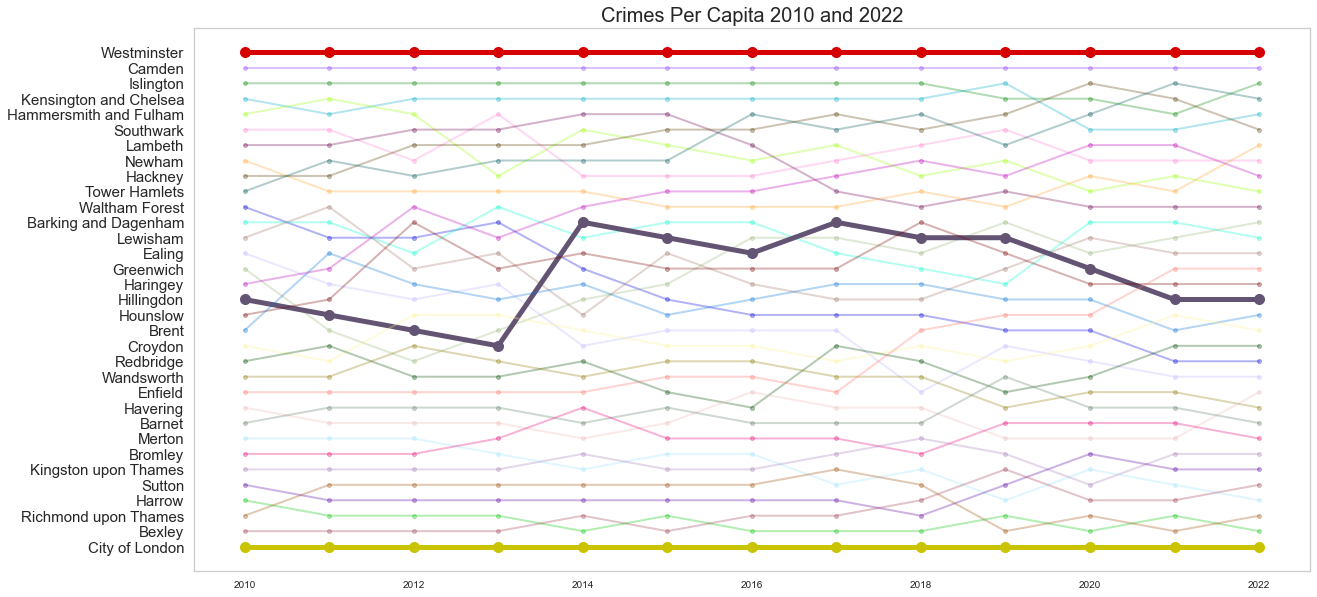

In [210]:
####
#### CREATE THE PLOTS - APPENDICES VERSION
#### 

palette = sns.color_palette(cc.glasbey, n_colors=len(borough_sort_order))
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())
ax = all_borough_ranking_by_year_df.T.plot(figsize=(20, 10), marker="o",  ms=1, cmap=my_cmap)



ax.grid(False)
ax.set_title("Crimes Per Capita {} and {}".format(year_from, year_to), fontsize=20)

plt.xticks(fontsize=20)

## Generate labels from the Borough names for the Y Axis

plt.yticks(range(1, len(borough_sort_order)+1), [borough_sort_order.iloc[i] for i in range(len(borough_sort_order))])
plt.yticks(fontsize=15)
plt.xticks(fontsize=10)

ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.gca().invert_yaxis()
plt.gca().get_legend().remove()

for line in ax.get_lines():
    if (line.get_label() == borough) or (line.get_label() == top_borough) or (line.get_label() == mid_borough) or (line.get_label() == bottom_borough):
        line.set_linewidth(5)
        line.set_ms(10)
    else:
        line.set_linewidth(2)
        line.set_ms(4)
        line.set_alpha(0.3)

plt.show(block=True)

### ETHNICITY

In [360]:
### Set up
%load_ext autoreload

%autoreload 3
from data.daos import dao_facade_local as dao_fac

db_conn = get_db_conn(database_props)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2022-08-14 17:09:47,067 [INFO] __main__: DATABASE CONNECTIVITY from 185.44.76.189


#### WARD

In [361]:
search_term = {"city"      : "London"
             , "ward_name" : "Holloway"
             , "borough"   : "Islington"
             , "post_code" : ""
             , "year_from" : "2011"
             , "year_to"   : "2022"}

borough = search_term["borough"]
ward_name = search_term["ward_name"]
###
### AVERAGE
###
ethnicity_average_year_df = dao_fac.ethnicity_ratio_average_years(db_conn)

## What's the latest year of data for ethnicity?
ethnicity_latest_data_year = ethnicity_average_year_df["YEAR"].max()

## Filter the dataframe to only include the latest data
ethnicity_average_year_df_latest = ethnicity_average_year_df.loc[ethnicity_average_year_df["YEAR"] == ethnicity_latest_data_year]

## Drop the columns we don't want in the plot

## Set the index for the plot, Borough
ethnicity_average_year_df_latest = ethnicity_average_year_df_latest.set_index("YEAR")
ethnicity_average_year_df_latest.index = ["Average"]
# ethnicity_average_year_df_latest


###
### WARD LEVEL
###
ethnicity_by_borough_ward_year_df = dao_fac.ethnicity_ratio_by_borough_ward_years(db_conn, search_term)

## What's the latest year of data for ethnicity?
ethnicity_latest_data_year = ethnicity_by_borough_ward_year_df["YEAR"].max()

## Filter the dataframe to only include the latest data
ethnicity_by_borough_ward_year_df_latest = ethnicity_by_borough_ward_year_df.loc[ethnicity_by_borough_ward_year_df["YEAR"] == ethnicity_latest_data_year]

## Drop the columns we don't want in the plot
ethnicity_by_borough_ward_year_df_reduced = ethnicity_by_borough_ward_year_df_latest.drop(["YEAR", "LAD", "LAD_NAME", "WARD_CODE"], axis=1)

## Set the index for the plot, Borough
ethnicity_by_borough_ward_year_df_reduced = ethnicity_by_borough_ward_year_df_reduced.set_index("WARD_NAME")
# ethnicity_by_borough_ward_year_df_reduced

###
### BOROUGH
###
ethnicity_by_borough_year_df = dao_fac.ethnicity_ratio_by_borough_years(db_conn)

## What's the latest year of data for ethnicity?
ethnicity_latest_data_year = ethnicity_by_borough_year_df["YEAR"].max()

## Filter the dataframe to only include the latest data
ethnicity_by_borough_year_df_latest = ethnicity_by_borough_year_df.loc[ethnicity_by_borough_year_df["YEAR"] == ethnicity_latest_data_year]

## Drop the columns we don't want in the plot
ethnicity_by_borough_year_df_reduced = ethnicity_by_borough_year_df_latest.drop(["YEAR", "LAD"], axis=1)


## Set the index for the plot, Borough
ethnicity_by_borough_year_df_reduced = ethnicity_by_borough_year_df_reduced.set_index("LAD_NAME")

## Make a copy to include all boroughs for the appendix
ethnicity_by_borough_year_df_all = ethnicity_by_borough_year_df_reduced.copy()

# ethnicity_by_borough_year_df_reduced 
# Only the borough we're interested in
ethnicity_by_borough_year_df_borough = ethnicity_by_borough_year_df_reduced[(ethnicity_by_borough_year_df_reduced.index == borough)]

# ethnicity_by_borough_year_df_reduced = ethnicity_by_borough_year_df_reduced[(ethnicity_by_borough_year_df_reduced.index != borough)]

# ethnicity_by_borough_year_df_reduced = pd.concat([ethnicity_by_borough_year_df_reduced, ethnicity_average_year_df_latest, ethnicity_by_borough_year_df_borough, ethnicity_by_borough_ward_year_df_reduced])
ethnicity_by_borough_year_df_reduced = pd.concat([ethnicity_average_year_df_latest, ethnicity_by_borough_year_df_borough, ethnicity_by_borough_ward_year_df_reduced])

# ethnicity_by_borough_year_df_borough
# ethnicity_by_borough_year_df_reduced



2022-08-14 17:09:47,676 [DEBUG] root: ethnicity_ratio_average_years


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-08-14 17:09:49,084 [DEBUG] root: ethnicity_ratio_by_borough_ward_years
2022-08-14 17:09:49,291 [DEBUG] root: ethnicity_ratio_by_borough_years


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


#### PLOT

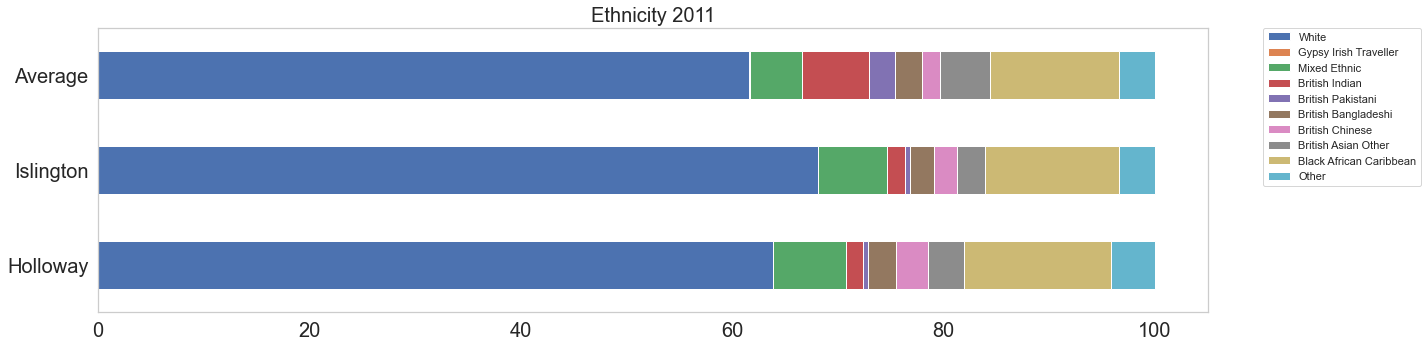

In [362]:
###
### HORIZONTAL PLOT 100% BY BOROUGH - REPORT
###

stacked_data = ethnicity_by_borough_year_df_reduced.apply(lambda x: x*100/sum(x), axis=1)

ax = stacked_data.plot.barh(stacked=True, figsize=(20, 5))

ax.grid(False)
ax.set_title("Ethnicity {}".format(ethnicity_latest_data_year), fontsize=20)
ax.set_ylabel("")
ax.legend(title="legend")
ax.legend(loc="upper right")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()


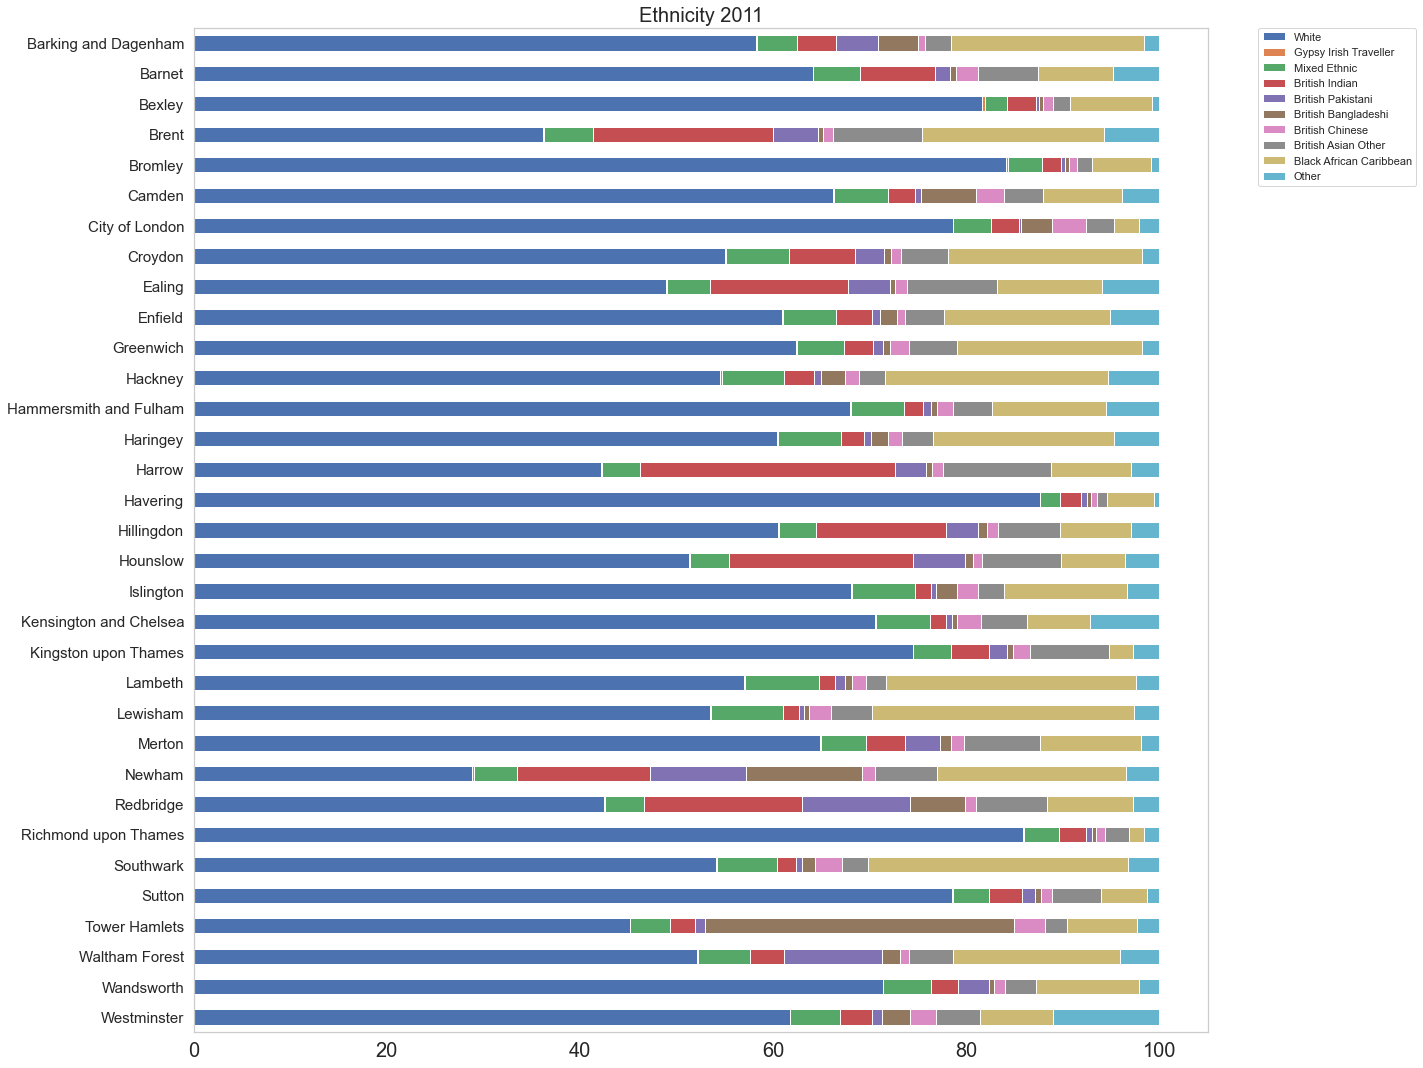

In [173]:
###
### HORIZONTAL PLOT 100% BY BOROUGH - APPENDIX
###

stacked_data = ethnicity_by_borough_year_df_all.apply(lambda x: x*100/sum(x), axis=1)

ax = stacked_data.plot.barh(stacked=True, figsize=(20, 15))

ax.grid(False)
ax.set_title("Ethnicity {}".format(ethnicity_latest_data_year), fontsize=20)
ax.set_ylabel("")
ax.legend(title="legend")
ax.legend(loc="upper right")

plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()


#### EDUCATION

In [377]:
search_term = {"city"      : "London"
             , "ward_name" : "Holloway"
             , "borough"   : "Islington"
             , "post_code" : ""
             , "year_from" : "2011"
             , "year_to"   : "2022"}

borough = search_term["borough"]
ward_name = search_term["ward_name"]

###
### EDUCATION
###

###
### AVERAGE
###
education_average_year_df = dao_fac.education_ratio_average_years(db_conn)

## What's the latest year of data for ethnicity?
latest_data_year = education_average_year_df["YEAR"].max()

## Filter the dataframe to only include the latest data
education_average_year_df_latest = education_average_year_df.loc[education_average_year_df["YEAR"] == latest_data_year]

## Drop the columns we don't want in the plot

## Set the index for the plot, Borough
education_average_year_df_latest = education_average_year_df_latest.set_index("YEAR")
education_average_year_df_latest.index = ["Average"]
education_average_year_df_latest


###
### WARD LEVEL
###
education_by_borough_ward_year_df = dao_fac.education_ratio_by_borough_ward_years(db_conn, search_term)

## What's the latest year of data for ethnicity?
education_latest_data_year = education_by_borough_ward_year_df["YEAR"].max()

## Filter the dataframe to only include the latest data
education_by_borough_ward_year_df_latest = education_by_borough_ward_year_df.loc[education_by_borough_ward_year_df["YEAR"] == latest_data_year]

## Drop the columns we don't want in the plot
education_by_borough_ward_year_df_reduced = education_by_borough_ward_year_df_latest.drop(["YEAR", "LAD", "LAD_NAME", "WARD_CODE"], axis=1)

## Set the index for the plot, Borough
education_by_borough_ward_year_df_reduced = education_by_borough_ward_year_df_reduced.set_index("WARD_NAME")
# education_by_borough_ward_year_df_reduced


###
### BOROUGH
###
education_by_borough_year_df = dao_fac.education_ratio_by_borough_years(db_conn)

## What's the latest year of data for education?
latest_data_year = education_by_borough_year_df["YEAR"].max()

## Filter the dataframe to only include the latest data
education_by_borough_year_df_latest = education_by_borough_year_df.loc[education_by_borough_year_df["YEAR"] == latest_data_year]

## Drop the columns we don't want in the plot
education_by_borough_year_df_reduced = education_by_borough_year_df_latest.drop(["YEAR", "LAD"], axis=1)

## Set the index for the plot, Borough
education_by_borough_year_df_reduced = education_by_borough_year_df_reduced.set_index("LAD_NAME")

# ethnicity_by_borough_year_df_reduced 
education_by_borough_year_df_borough = education_by_borough_year_df_reduced[(education_by_borough_year_df_reduced.index == borough)]



# education_by_borough_year_df_reduced = education_by_borough_year_df_reduced[(education_by_borough_year_df_reduced.index != borough)]

education_by_borough_year_df_all = education_by_borough_year_df_reduced
education_by_borough_year_df_reduced = pd.concat([education_average_year_df_latest, education_by_borough_year_df_borough, education_by_borough_ward_year_df_reduced])


education_by_borough_year_df_reduced

,None,Level 1,Level 2,Level 3,Level 4,Other,Apprenticeship,FT Student 16 17,FT Student 18+,FT Student 18+ Employed,FT Student 18+ Unemployed
Average,0.169326,0.103624,0.115620,0.103210,0.394002,0.098074,0.016143,0.025142,0.078549,0.024250,0.007508
Islington,0.169834,0.080361,0.083976,0.097535,0.480669,0.077566,0.010060,0.018629,0.107132,0.024531,0.008662
Holloway,0.188078,0.084196,0.086884,0.111471,0.433394,0.086252,0.009724,0.023006,0.149182,0.033520,0.013361


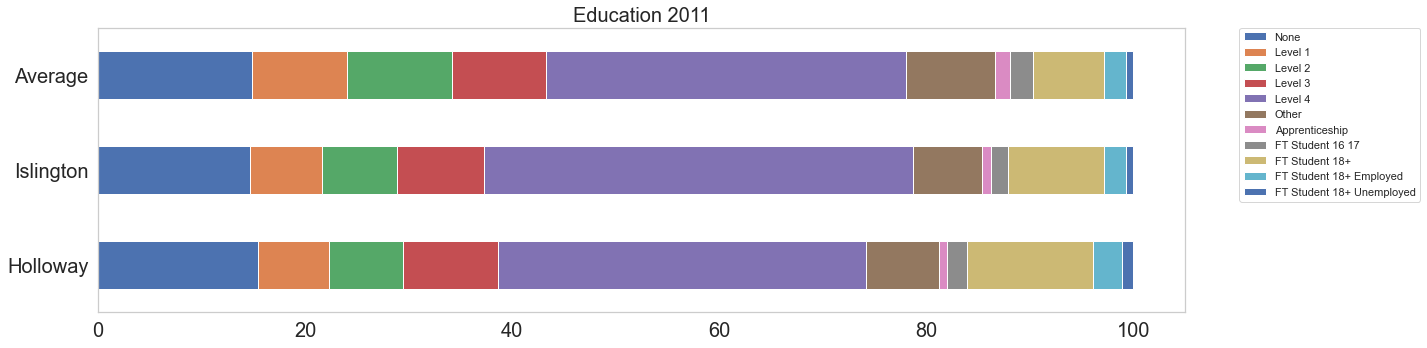

In [378]:
###
### HORIZONTAL PLOT 100% BY BOROUGH - REPORT
###

stacked_data = education_by_borough_year_df_reduced.apply(lambda x: x*100/sum(x), axis=1)

ax = stacked_data.plot.barh(stacked=True, figsize=(20, 5))

ax.grid(False)
ax.set_title("Education {}".format(education_latest_data_year), fontsize=20)
ax.set_ylabel("")
ax.legend(title="legend")
ax.legend(loc="upper right")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

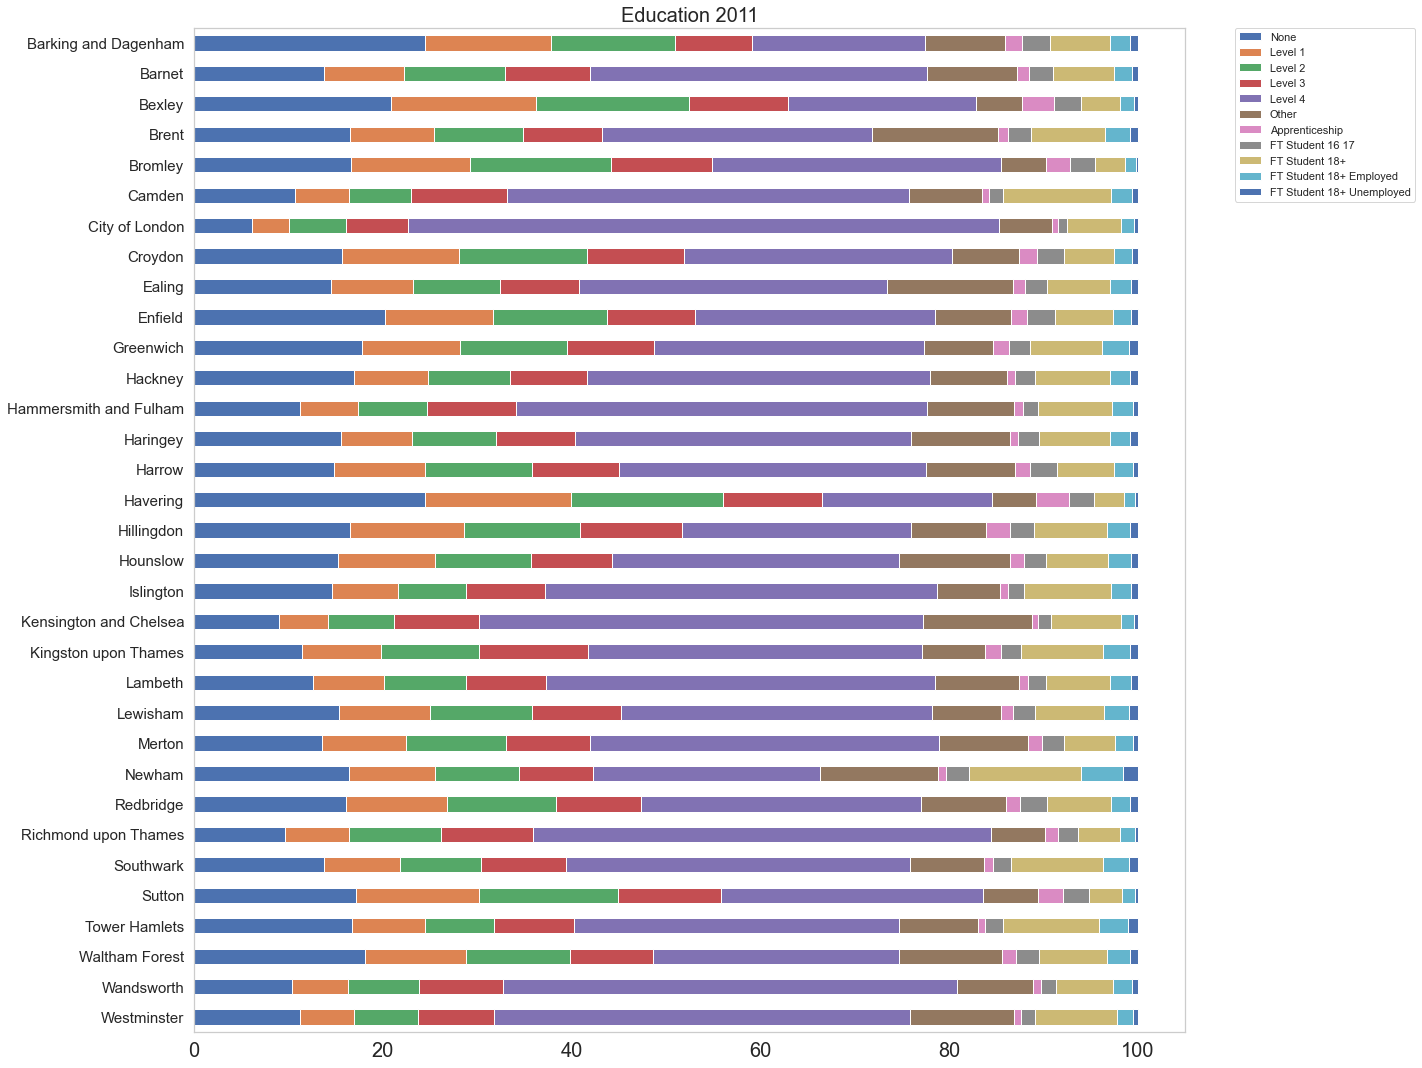

In [379]:
###
### HORIZONTAL PLOT 100% BY BOROUGH - APPENDIX
###

stacked_data = education_by_borough_year_df_all.apply(lambda x: x*100/sum(x), axis=1)

ax = stacked_data.plot.barh(stacked=True, figsize=(20, 15))

ax.grid(False)
ax.set_title("Education {}".format(education_latest_data_year), fontsize=20)
ax.set_ylabel("")
ax.legend(title="legend")
ax.legend(loc="upper right")

plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()